### Import
For Load Data Section

In [1]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import module_plot as m_plot # local module
import importlib

# Load Data

To develop a generalizable architecture for fault diagnosis, we utilize two benchmark datasets: **KAIST** and **CWRU**.

- **KAIST Dataset:** The Korea Advanced Institute of Science & Technology (KAIST) dataset contains vibration signals from rotating machinery under various fault types, motor loads, and fault severities. It provides a diverse set of conditions, making it suitable for robust model training and evaluation.

- **CWRU Dataset:** The Case Western Reserve University (CWRU) bearing dataset is widely used for bearing fault diagnosis research. It includes vibration data collected under different fault types, locations, and loads.

By training the ML model on both KAIST and CWRU datasets, we aim to demonstrate its ability to generalize across different machines, fault types, and operating conditions.

## KAIST Dataset

The KAIST Dataset (Jung2022) has 4 sensed variables: acoustic, current, temperature, and vibration. In this case, only vibration will be used.
- **Machine Conditions (Normal, BPFI, BPFO, Misalign, and Unbalance):** Fault types and normal operating condition
- **Motor load (0Nm, 2Nm, 4Nm):** Torque applied to the motor simulating load
- **Fault Severity:** Depending on the type of fault there are at least 3 severities. For example BPFI has a fault severity represented in the crack width (0.3mm, 1mm, 3mm)

In [4]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio

# ------------------------------ KAIST Dataset ------------------------------
vibration_mat_folder_kaist = '../../data/raw_kaist/vibration_mat_25.6kHz'
sampling_rate_kaist = 25600  # fixed at 25.6 kHz

# Mapping original → unified
kaist_map = {
    '0Nm_Normal': 'Normal',
    '0Nm_BPFI_03': 'BPFI',
    '0Nm_BPFO_03': 'BPFO',
    '0Nm_Misalign_01': 'Misalign',
    '0Nm_Unbalance_0583mg': 'Unbalance'
}

def load_domain_data_kaist(class_labels, domain_name, label_map=None):
    """Load vibration data for a KAIST domain with emoji-style verbose logging."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/kaist_csv/vibration{sampling_rate_kaist/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"🚀 Loading KAIST domain {domain_name}...")
    for label in class_labels:
        unified_label = label_map[label] if label_map else label
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_kaist, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"📂 Loading cached CSV for {label} → {unified_label}")
            data = pd.read_csv(csv_path).values.astype('float32')
        elif os.path.exists(mat_path):
            print(f"📥 Loading {label} from .mat as {unified_label}")
            m = sio.loadmat(mat_path)
            data = m['Signal']['y_values'][0][0][0][0][0].astype('float32')
            pd.DataFrame(data).to_csv(csv_path, index=False)
            print(f"💾 Saved CSV {csv_path}")
        else:
            print(f"❌ {label} not found")
            continue

        if unified_label not in vibration_data:
            vibration_data[unified_label] = []
        vibration_data[unified_label].append(data)

    for k in vibration_data:
        print(f"🔗 Concatenating {len(vibration_data[k])} segments for class {k}")
        vibration_data[k] = np.concatenate(vibration_data[k], axis=0)

    print(f"✅ Finished loading KAIST: {list(vibration_data.keys())}")
    return vibration_data

# Example usage
vibration_data_kaist_unified = load_domain_data_kaist(list(kaist_map.keys()), '0Nm', label_map=kaist_map)
class_labels_kaist_unified = list(vibration_data_kaist_unified.keys())


🚀 Loading KAIST domain 0Nm...
📂 Loading cached CSV for 0Nm_Normal → Normal
📂 Loading cached CSV for 0Nm_BPFI_03 → BPFI
📂 Loading cached CSV for 0Nm_BPFO_03 → BPFO
📂 Loading cached CSV for 0Nm_Misalign_01 → Misalign
📂 Loading cached CSV for 0Nm_Unbalance_0583mg → Unbalance
🔗 Concatenating 1 segments for class Normal
🔗 Concatenating 1 segments for class BPFI
🔗 Concatenating 1 segments for class BPFO
🔗 Concatenating 1 segments for class Misalign
🔗 Concatenating 1 segments for class Unbalance
✅ Finished loading KAIST: ['Normal', 'BPFI', 'BPFO', 'Misalign', 'Unbalance']


### Plot Random KAIST signal

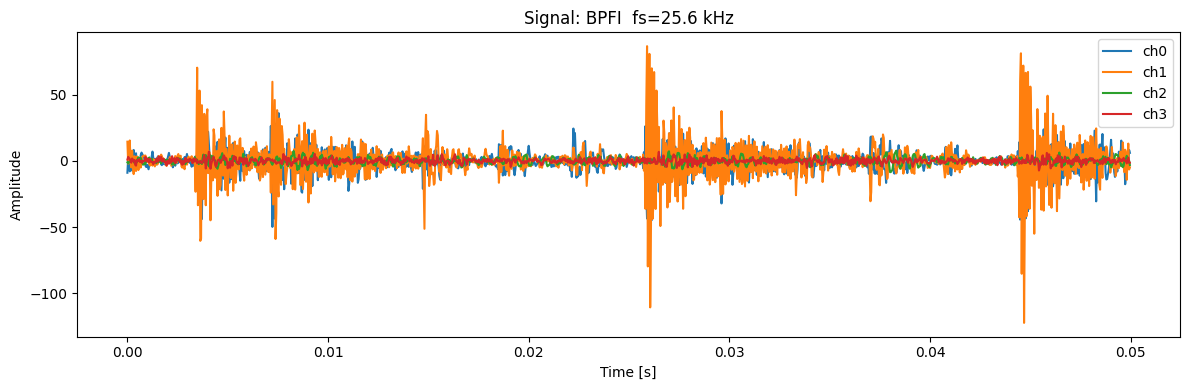

In [5]:
# Plot KAIST signals
m_plot.plot_signal(vibration_data_kaist_unified, fs=sampling_rate_kaist, seconds=0.05) # plots random examples from all classes
# m_plot.plot_signal(vibration_data_kaist, fs=sampling_rate_kaist, seconds=0.05, label='0Nm_Normal', channels=[0])

## CWRU Dataset

The Case Western Reserve University (CWRU) Bearing Dataset provides vibration measurements collected from a motor test rig with seeded bearing faults. Acceleration data was captured near the motor bearings under varying load and fault conditions.

- **Machine Conditions (Normal, Inner Race, Outer Race, and Ball Faults):** Single-point faults were introduced using electro-discharge machining (EDM) at the inner race, outer race, or rolling element. Normal operating condition data is also included.  
- **Motor Load (0–3 hp):** Torque loads applied to the 2 hp Reliance Electric motor, corresponding to operating speeds between 1720 and 1797 RPM.  
- **Fault Severity:** Fault diameters of 0.007, 0.014, 0.021, 0.028, and 0.040 inches were tested. SKF bearings were used for smaller faults (7–21 mils) and NTN bearings for larger faults (28–40 mils).  
- **Sensor Setup:** Vibration was recorded using accelerometers placed at the 12 o’clock position of the drive end and fan end bearings. Additional measurements were taken at the base plate in some experiments.  
- **Sampling Rate:** Signals were collected at 12 kHz for most cases, with 48 kHz recordings available for drive end bearing faults.  


In [6]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import resample_poly

# ------------------------------ CWRU Dataset ------------------------------
vibration_mat_folder_cwru = '../../data/raw_cwru/vibration_mat_12kHz'
sampling_rate_cwru = 12000
target_sampling_rate_cwru = 25600

# Exact 12 kHz to 25.6 kHz ratio
UPSAMPLE, DOWNSAMPLE = 32, 15
assert target_sampling_rate_cwru * DOWNSAMPLE == sampling_rate_cwru * UPSAMPLE

def load_domain_data_cwru(class_labels, domain_name, label_map=None, max_src_len=260868):
    """Load CWRU domain with emoji style verbose logging. Resamples to target rate and remaps labels if label_map is given."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/cwru_csv/vibration{target_sampling_rate_cwru/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"🚀 Loading CWRU domain {domain_name} at {target_sampling_rate_cwru} Hz...")
    for label in class_labels:
        unified_label = label_map[label] if label_map else label
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_cwru, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"📂 Loading cached CSV for {label} → {unified_label}")
            data_resampled = pd.read_csv(csv_path).values.astype(np.float32)

        elif os.path.exists(mat_path):
            print(f"📥 Loading {label} from .mat as {unified_label}")
            m = sio.loadmat(mat_path)

            # Extract DE FE BA if present
            series, lengths = [], []
            for ch in ('DE', 'FE', 'BA'):
                key = next((k for k in m.keys() if not k.startswith('__') and k.endswith(f'_{ch}_time')), None)
                if key:
                    a = np.asarray(m[key]).squeeze().astype(np.float32)
                    if a.ndim != 1:
                        a = a.reshape(-1)
                    series.append(a)
                    lengths.append(a.shape[0])

            if not series:
                print(f"❌ No DE FE BA channels in {label}. Skipping")
                continue

            n = min(min(lengths), int(max_src_len))
            x = np.stack([s[:n] for s in series], axis=1)  # [T, C]

            print(f"🔄 Resampling {label} from {sampling_rate_cwru} Hz → {target_sampling_rate_cwru} Hz")
            data_resampled = resample_poly(x, UPSAMPLE, DOWNSAMPLE, axis=0).astype(np.float32)

            pd.DataFrame(data_resampled).to_csv(csv_path, index=False)
            print(f"💾 Saved CSV {csv_path}")

        else:
            print(f"⚠️ {label} not found in cache or mats")
            continue

        if unified_label not in vibration_data:
            vibration_data[unified_label] = []
        vibration_data[unified_label].append(data_resampled)

    # Concatenate per class using common channel count
    for k in list(vibration_data.keys()):
        print(f"🔗 Concatenating {len(vibration_data[k])} segments for class {k}")
        cmin = min(arr.shape[1] for arr in vibration_data[k])
        vibration_data[k] = np.concatenate([arr[:, :cmin] for arr in vibration_data[k]], axis=0).astype(np.float32)

    print(f"✅ Finished loading CWRU: {list(vibration_data.keys())}")
    return vibration_data

# Mapping CWRU with KAIST call style
cwru_map = {
    'Normal_0': 'Normal',
    'IR007_0':  'BPFI',
    'OR007@3_0': 'BPFO',
    'OR007@6_0': 'BPFO',
    'OR007@12_0': 'BPFO',
    'B007_0':   'Ball',   # change to 'BPFI' if you prefer the intersection scheme
}

vibration_data_cwru_unified = load_domain_data_cwru(list(cwru_map.keys()), '0HP', label_map=cwru_map)
class_labels_cwru_unified = list(vibration_data_cwru_unified.keys())


🚀 Loading CWRU domain 0HP at 25600 Hz...
📂 Loading cached CSV for Normal_0 → Normal
📂 Loading cached CSV for IR007_0 → BPFI
📂 Loading cached CSV for OR007@3_0 → BPFO
📂 Loading cached CSV for OR007@6_0 → BPFO
📂 Loading cached CSV for OR007@12_0 → BPFO
📂 Loading cached CSV for B007_0 → Ball
🔗 Concatenating 1 segments for class Normal
🔗 Concatenating 1 segments for class BPFI
🔗 Concatenating 3 segments for class BPFO
🔗 Concatenating 1 segments for class Ball
✅ Finished loading CWRU: ['Normal', 'BPFI', 'BPFO', 'Ball']


Plot Random signal CWRU

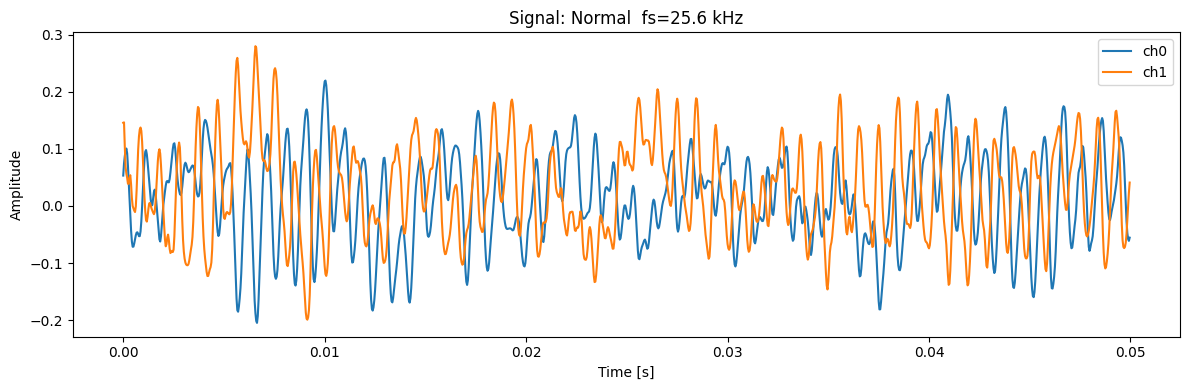

In [7]:
# CWRU after your resampling step at 25.6 kHz
m_plot.plot_signal(vibration_data_cwru_unified, fs=target_sampling_rate_cwru, seconds=0.05) # plots random examples from all classes
# m_plot.plot_signal(vibration_data_cwru, fs=sampling_rate_cwru, seconds=0.05, label='Normal_0')

### Resampling visualization CWRU Dataset

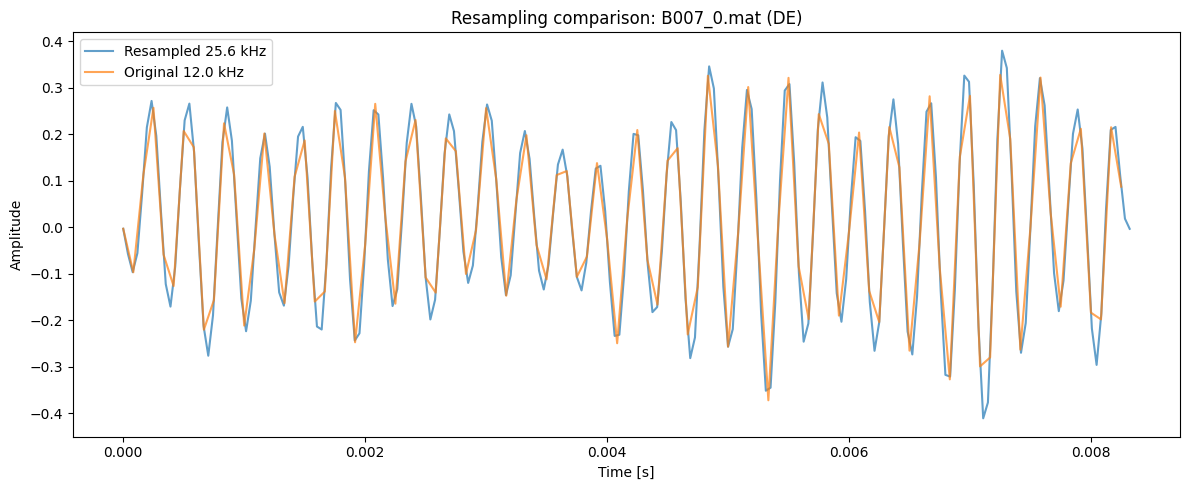

In [8]:
mat_path = "../../data/raw_cwru/vibration_mat_12kHz/B007_0.mat"
m_plot.compare_resampling(mat_path, channel="DE", max_len=100)

# Feature Extraction

In [9]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft

def extract_features_dataset(
    data_dict,
    class_labels,
    window_size,
    stride=None,
    hilbert_channels=(0, 3),
    fixed_channels=None,
    auto_common=True
):
    """
    Returns:
      X: [segments, window_size//2, C] with consistent C across all samples
      y: [segments] integer class ids aligned to class_labels
      used_channels: list of channel indices used in X
      seg_meta: list of dicts with label and segment info
    """
    if stride is None:
        stride = window_size

    # Decide consistent channels
    if fixed_channels is not None:
        used_channels = list(fixed_channels)
    elif auto_common:
        # Use the minimum channel count across available arrays
        ch_counts = []
        for lbl in class_labels:
            if lbl in data_dict:
                arr = data_dict[lbl]
                if arr.ndim == 1:
                    arr = arr[:, None]
                ch_counts.append(arr.shape[1])
        if not ch_counts:
            raise ValueError("No arrays found for the provided class_labels")
        min_c = int(min(ch_counts))
        if min_c < 1:
            raise ValueError("Detected zero channels")
        used_channels = list(range(min_c))
    else:
        # Default to the first array shape
        first_lbl = next(lbl for lbl in class_labels if lbl in data_dict)
        first_arr = data_dict[first_lbl]
        if first_arr.ndim == 1:
            first_arr = first_arr[:, None]
        used_channels = list(range(first_arr.shape[1]))

    feats = []
    y_list = []
    seg_meta = []

    for cls_id, lbl in enumerate(class_labels):
        if lbl not in data_dict:
            continue
        arr = data_dict[lbl]
        if arr.ndim == 1:
            arr = arr[:, None]

        # If any requested channel is out of range, skip this label entirely
        if any(ch >= arr.shape[1] for ch in used_channels):
            # skip arrays lacking required channels
            continue

        x = arr[:, used_channels]  # enforce consistent channels
        n, c = x.shape
        if n < window_size:
            continue

        starts = np.arange(0, n - window_size + 1, stride, dtype=int)
        for s in starts:
            seg = x[s:s + window_size, :]  # [win, C]

            # Z score per channel
            mu = seg.mean(axis=0, keepdims=True)
            sd = seg.std(axis=0, keepdims=True)
            sd = np.where(sd == 0, 1e-8, sd)
            seg_z = (seg - mu) / sd

            # Hilbert envelope on selected channels if they exist
            seg_proc = seg_z.copy()
            for hch in hilbert_channels:
                if 0 <= hch < seg_proc.shape[1]:
                    seg_proc[:, hch] = np.abs(hilbert(seg_proc[:, hch]))

            # FFT magnitude positive half per channel
            spec = np.abs(fft(seg_proc, axis=0))[:window_size // 2, :]  # [bins, C]
            feats.append(spec.astype(np.float32))
            y_list.append(cls_id)
            seg_meta.append({
                "label": lbl,
                "start": int(s),
                "end": int(s + window_size),
                "channels_used": used_channels
            })

    if not feats:
        raise ValueError("No segments extracted. Check window_size, stride, and channels policy.")

    X = np.stack(feats, axis=0)  # [Nseg, bins, C] now consistent
    y = np.array(y_list, dtype=np.int64)
    return X, y, used_channels, seg_meta

# KAIST
X_kaist, y_kaist, ch_kaist, meta_kaist = extract_features_dataset(
    vibration_data_kaist_unified, class_labels_kaist_unified,
    window_size=5120, stride=5120, fixed_channels=[0]
)

class_labels_unified = ['Normal', 'BPFI', 'BPFO', 'Misalign', 'Unbalance', 'Ball']  # CWRU Dataset use this labels for Transfer Learning

# CWRU at 25.6 kHz after resampling
X_cwru, y_cwru, ch_cwru, meta_cwru = extract_features_dataset(
    vibration_data_cwru_unified, class_labels_unified,
    window_size=5120, stride=5120, fixed_channels=[0]
)

In [11]:
print("Available CWRU keys:", vibration_data_cwru_unified.keys())

for lbl in class_labels_unified:
    arr = vibration_data_cwru_unified.get(lbl)
    if arr is None:
        print(f"{lbl}: MISSING in data_dict")
        continue
    if arr.ndim == 1:
        arr = arr[:, None]
    n, c = arr.shape
    print(f"{lbl}: shape {arr.shape}")
    if n < 5120:
        print(f"  WARNING {lbl} has length {n} < window_size 5120")
    if 0 >= c:
        print(f"  WARNING {lbl} has no channel zero")


Available CWRU keys: dict_keys(['Normal', 'BPFI', 'BPFO', 'Ball'])
Normal: shape (520402, 2)
BPFI: shape (258699, 3)
BPFO: shape (781982, 3)
Misalign: MISSING in data_dict
Unbalance: MISSING in data_dict
Ball: shape (261485, 3)


In [12]:
import collections

counter = collections.Counter(y_cwru)
for cls_id, lbl in enumerate(class_labels_unified):
    print(lbl, "segments:", counter.get(cls_id, 0))


Normal segments: 101
BPFI segments: 50
BPFO segments: 152
Misalign segments: 0
Unbalance segments: 0
Ball segments: 51


Summarize Features


[KAIST] Summary
  Shape X: (3300, 2560, 1)  y: (3300,)
  Channels: 1  Bins: 2560
  Stats  min:0.003  max:6521.695  mean:31.916
  NaN present: False  Inf present: False
  Samples per class:
   - Normal: 1500
   - BPFI: 300
   - BPFO: 300
   - Misalign: 600
   - Unbalance: 600
   - Ball: 0
  Mean spectral energy per channel: [45748676.]


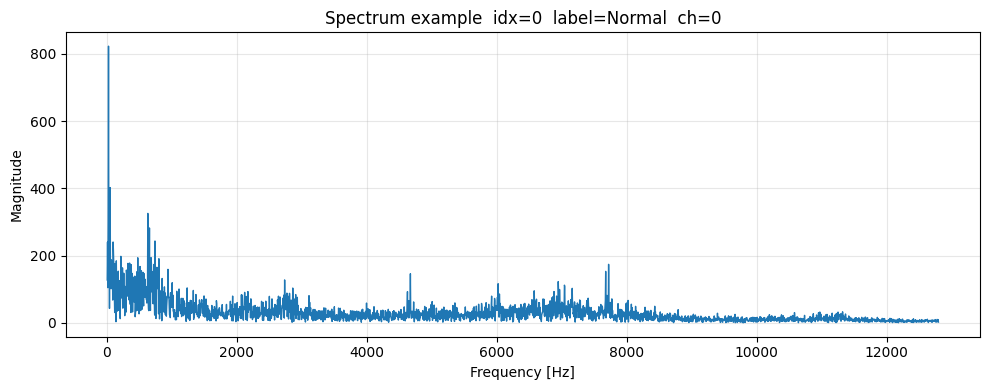

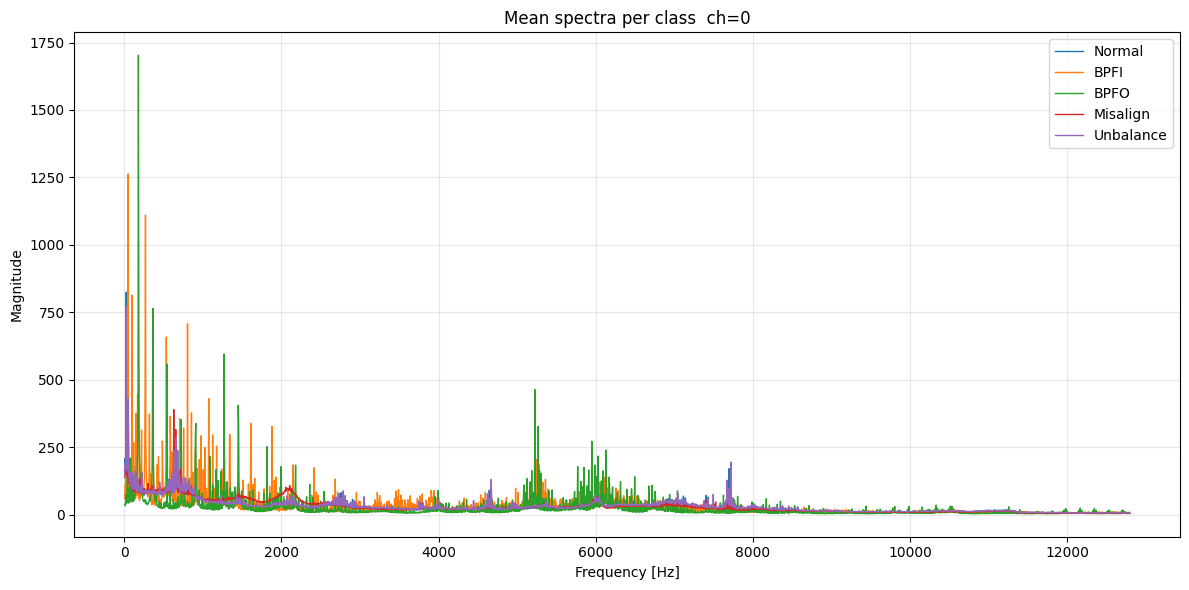


[CWRU] Summary
  Shape X: (354, 2560, 1)  y: (354,)
  Channels: 1  Bins: 2560
  Stats  min:0.001  max:6602.408  mean:18.555
  NaN present: False  Inf present: False
  Samples per class:
   - Normal: 101
   - BPFI: 50
   - BPFO: 152
   - Misalign: 0
   - Unbalance: 0
   - Ball: 51
  Mean spectral energy per channel: [44021464.]


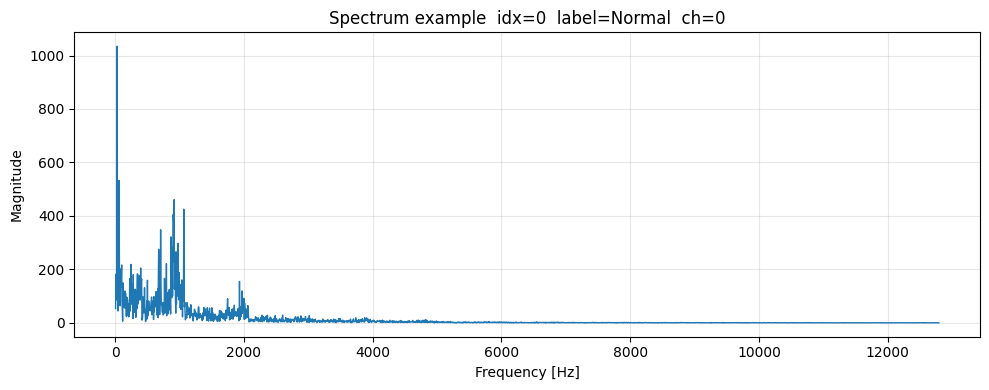

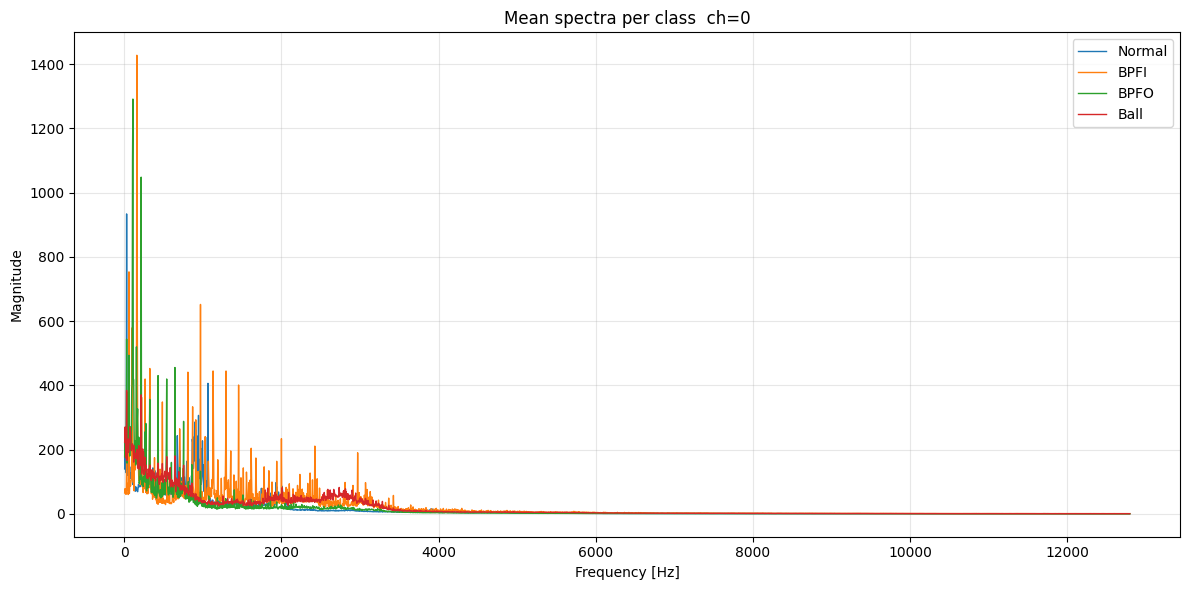

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def summarize_features(X, y, class_labels, name="dataset"):
    """
    Quick integrity report for feature tensors.
    X: [n_segments, n_bins, n_channels]
    y: [n_segments] integer ids aligned with class_labels
    """
    assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
    assert X.ndim == 3, f"X must be 3D [segments, bins, channels], got {X.shape}"
    assert y.ndim == 1, f"y must be 1D [segments], got {y.shape}"
    assert X.shape[0] == y.shape[0], "Segments count mismatch between X and y"

    # NaN or Inf check
    has_nan = np.isnan(X).any()
    has_inf = np.isinf(X).any()

    # Basic stats
    n_segments, n_bins, n_channels = X.shape
    value_min = float(np.nanmin(X))
    value_max = float(np.nanmax(X))
    value_mean = float(np.nanmean(X))

    # Label coverage
    cnt = Counter(y.tolist())
    label_rows = []
    for i, lbl in enumerate(class_labels):
        label_rows.append((lbl, cnt.get(i, 0)))

    print(f"\n[{name}] Summary")
    print(f"  Shape X: {X.shape}  y: {y.shape}")
    print(f"  Channels: {n_channels}  Bins: {n_bins}")
    print(f"  Stats  min:{value_min:.3f}  max:{value_max:.3f}  mean:{value_mean:.3f}")
    print(f"  NaN present: {has_nan}  Inf present: {has_inf}")
    print("  Samples per class:")
    for lbl, n in label_rows:
        print(f"   - {lbl}: {n}")

    # Simple per channel energy check
    energy = np.mean(np.sum(X**2, axis=1), axis=0)  # mean over segments of sum over bins per channel
    print("  Mean spectral energy per channel:", np.round(energy, 3))
    
def plot_feature_example(X, y, class_labels, fs, label=None, idx=None, channel=0):
    """
    Plot one feature vector: magnitude spectrum of a chosen segment and channel.
    If label is given chooses the first sample of that class. If idx is given uses that index.
    """
    n_segments, n_bins, n_channels = X.shape
    if channel >= n_channels:
        raise ValueError(f"channel {channel} out of range {n_channels}")

    if idx is None:
        if label is None:
            idx = 0
        else:
            cls_id = class_labels.index(label)
            where = np.where(y == cls_id)[0]
            if len(where) == 0:
                raise ValueError(f"No segments for label {label}")
            idx = int(where[0])
 
    freqs = np.fft.fftfreq(n_bins*2, d=1/fs)[:n_bins]  # consistent with window_size//2 bins
    spec = X[idx, 1:, channel]  # remove DC (first bin)
    freqs = freqs[1:]           # remove DC frequency

    plt.figure(figsize=(10,4))
    plt.plot(freqs, spec, lw=1)
    ttl_label = class_labels[y[idx]] if 0 <= y[idx] < len(class_labels) else f"id {y[idx]}"
    plt.title(f"Spectrum example  idx={idx}  label={ttl_label}  ch={channel}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_class_mean_spectra(X, y, class_labels, fs, channel=0):
    """
    Plot mean spectrum per class for a chosen channel for a quick separability check.
    """
    n_segments, n_bins, n_channels = X.shape
    if channel >= n_channels:
        raise ValueError(f"channel {channel} out of range {n_channels}")
    freqs = np.fft.fftfreq(n_bins*2, d=1/fs)[:n_bins]
    freqs = freqs[1:]  # remove DC frequency

    plt.figure(figsize=(12,6))
    for cid, lbl in enumerate(class_labels):
        idxs = np.where(y == cid)[0]
        if len(idxs) == 0:
            continue
        mean_spec = X[idxs, 1:, channel].mean(axis=0)
        plt.plot(freqs, mean_spec, lw=1, label=lbl)
    plt.title(f"Mean spectra per class  ch={channel}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# KAIST
summarize_features(X_kaist, y_kaist, class_labels_unified, name="KAIST")
plot_feature_example(X_kaist, y_kaist, class_labels_unified, fs=sampling_rate_kaist, label=class_labels_kaist_unified[0], channel=0)
plot_class_mean_spectra(X_kaist, y_kaist, class_labels_unified, fs=sampling_rate_kaist, channel=0)

# CWRU
summarize_features(X_cwru, y_cwru, class_labels_unified, name="CWRU")
plot_feature_example(X_cwru, y_cwru, class_labels_unified, fs=target_sampling_rate_cwru, label=class_labels_cwru_unified[0], channel=0)
plot_class_mean_spectra(X_cwru, y_cwru, class_labels_unified, fs=target_sampling_rate_cwru, channel=0)


Plot KAIST Feature Extraction

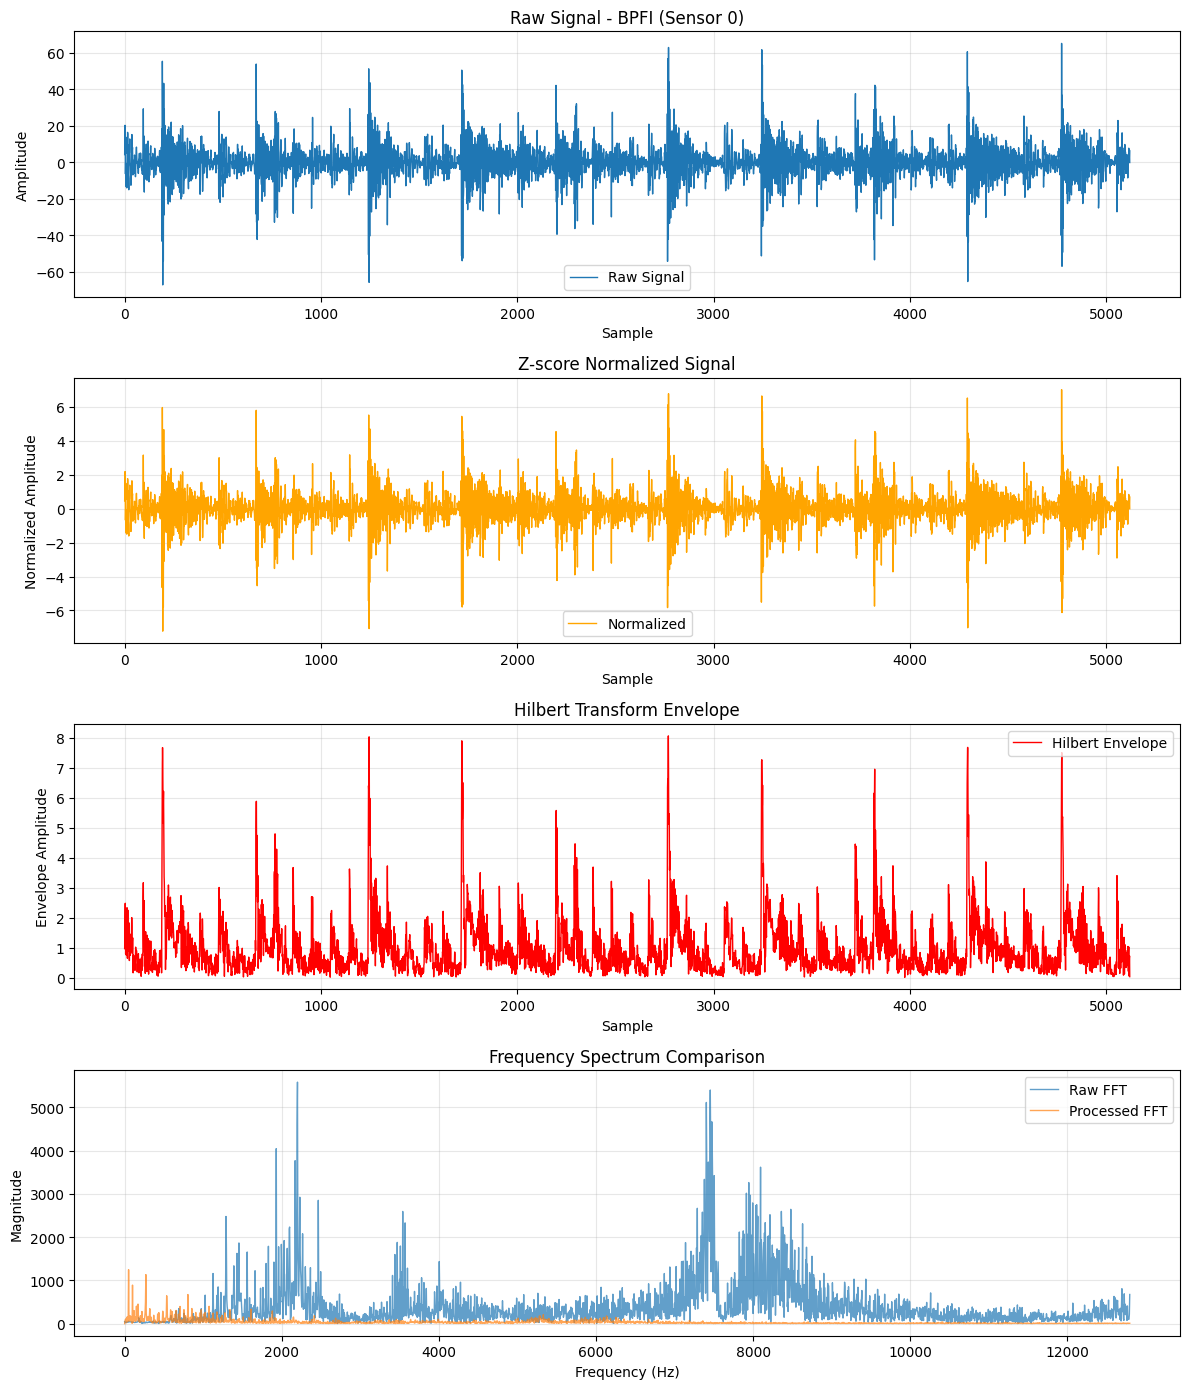

In [28]:
sampling_rate_unified = sampling_rate_kaist  # since both datasets are now at 25.6 kHz
m_plot.plot_signal_examples(vibration_data_kaist_unified, class_labels_kaist_unified, sampling_rate_unified, window_size=5120)

Plot CWRU Feature Extraction

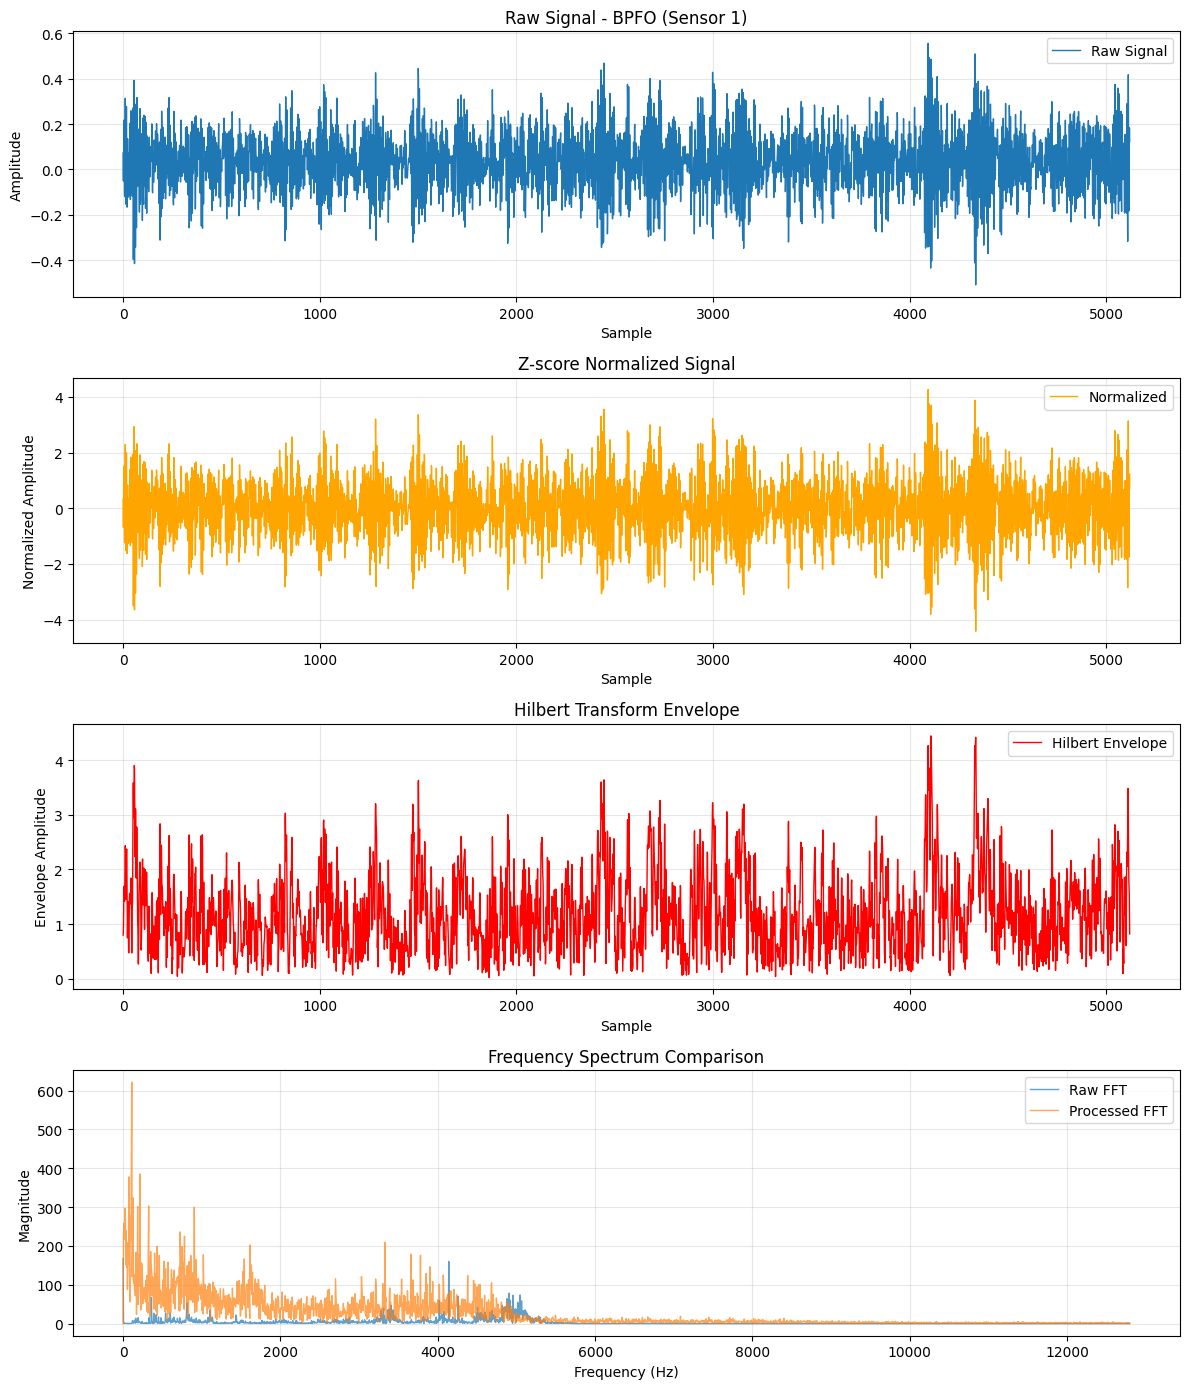

In [29]:
m_plot.plot_signal_examples(vibration_data_cwru_unified, class_labels_cwru_unified, sampling_rate_unified, window_size=5120)

# Model Definition

## Build Backbone model (KAIST)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, Dense, Input

def build_model(input_shape, num_classes=5):
    model = Sequential([
        Input(shape=input_shape),

        # Conv Block 1
        Conv1D(filters=32, kernel_size=33, strides=6, padding='same',
               kernel_initializer='he_normal', use_bias=False),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),

        # Conv Block 2
        Conv1D(filters=64, kernel_size=9, strides=3, padding='same',
               kernel_initializer='he_normal', use_bias=False),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),

        # Conv Block 3
        Conv1D(filters=128, kernel_size=3, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=False),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),

        # Global average pooling over time
        GlobalAveragePooling1D(),

        # Dense head
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])
    return model



In [31]:
from sklearn.model_selection import KFold
import seaborn as sns

# 1) Build KAIST features with one channel
X, y_int, used_ch, meta = X_kaist, y_kaist, ch_kaist, meta_kaist

X = X.astype("float32")                 # [N, 2560, 1]
Y = tf.keras.utils.to_categorical(y_int, num_classes=len(class_labels_kaist_unified))

# 2) Define input shape directly from X
input_shape = (X.shape[1], X.shape[2])  # (2560, 1)

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

save_dir = '../models_kaist0'

os.makedirs(save_dir, exist_ok=True)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}/{k}")

    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    model = build_model(input_shape, num_classes=len(class_labels_kaist_unified))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        ModelCheckpoint(os.path.join(save_dir, f"kaist_model0_fold_{fold}.keras"),
                        monitor="val_accuracy", save_best_only=True)
    ]

    model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2,
              validation_data=(X_test, Y_test), callbacks=callbacks)

    # Predict and evaluate
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Plot confusion matrix with class numbers
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=np.arange(len(class_labels_kaist_unified)),  # numbers on axes
                yticklabels=np.arange(len(class_labels_kaist_unified)))

    plt.xlabel("Predicted (class number)")
    plt.ylabel("Actual (class number)")
    plt.title(f"Confusion Matrix (Fold {fold})")

    # Add legend mapping numbers to classes
    handles = [plt.Rectangle((0,0),1,1, color="white", ec="white", alpha=0)] * len(class_labels_kaist_unified)
    labels = [f"{i}: {cls}" for i, cls in enumerate(class_labels_kaist_unified)]
    plt.legend(handles, labels, title="Class mapping",
            bbox_to_anchor=(1.3, 1), loc="upper left")

    cm_filename = os.path.join(save_dir, f"confusion_matrix_fold_{fold}.png")
    plt.savefig(cm_filename, bbox_inches="tight")
    plt.close()
    print(f"Saved confusion matrix for fold {fold} at {cm_filename}")

    # Per fold report
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    all_reports.append(rep)

    rep_df = pd.DataFrame(rep).transpose()
    rep_path = os.path.join(save_dir, f"classification_report_fold_{fold}.csv")
    rep_df.to_csv(rep_path)
    print(f"Saved classification report for fold {fold} at {rep_path}")

# ---------- Aggregate reports: mean ± std ----------
# Convert nested dicts to DataFrames and keep numeric columns
report_dfs = []
for rep in all_reports:
    df = pd.DataFrame(rep).transpose()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    report_dfs.append(df)

metrics = ["precision", "recall", "f1-score"]
labels = report_dfs[0].index.tolist()

metric_stack = {m: np.stack([df[m].values for df in report_dfs], axis=0) for m in metrics}
support_stack = np.stack([df["support"].values for df in report_dfs], axis=0)

rows = []
for i, lab in enumerate(labels):
    row = []
    for m in metrics:
        vals = metric_stack[m][:, i]
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        row.append(f"{mean:.4f} ± {std:.4f}")
    row.append(int(np.nanmean(support_stack[:, i])))
    rows.append(row)

final_report_df = pd.DataFrame(rows,
                               columns=["Precision", "Recall", "F1-score", "Support"],
                               index=labels)

final_csv = os.path.join(save_dir, "final_averaged_report.csv")
final_report_df.to_csv(final_csv)
print(f"Final Averaged Report saved at {final_csv}")

# Optional: render the final table as an image
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("off")
tbl = ax.table(cellText=final_report_df.values,
               colLabels=final_report_df.columns,
               rowLabels=final_report_df.index,
               cellLoc="center", loc="center")
plt.savefig(os.path.join(save_dir, "final_report_table.png"),
            bbox_inches="tight", dpi=300)
plt.close()



Fold 1/5
Epoch 1/100
83/83 - 3s - 35ms/step - accuracy: 0.8167 - loss: 0.4965 - val_accuracy: 0.5485 - val_loss: 0.9609
Epoch 2/100
83/83 - 1s - 11ms/step - accuracy: 0.9614 - loss: 0.1167 - val_accuracy: 0.8682 - val_loss: 0.2864
Epoch 3/100
83/83 - 1s - 10ms/step - accuracy: 0.9852 - loss: 0.0522 - val_accuracy: 0.7530 - val_loss: 0.7973
Epoch 4/100
83/83 - 1s - 11ms/step - accuracy: 0.9894 - loss: 0.0364 - val_accuracy: 0.9258 - val_loss: 0.1739
Epoch 5/100
83/83 - 1s - 12ms/step - accuracy: 0.9962 - loss: 0.0172 - val_accuracy: 0.9470 - val_loss: 0.1488
Epoch 6/100
83/83 - 1s - 10ms/step - accuracy: 0.9939 - loss: 0.0186 - val_accuracy: 0.9545 - val_loss: 0.1123
Epoch 7/100
83/83 - 1s - 10ms/step - accuracy: 0.9973 - loss: 0.0121 - val_accuracy: 0.9939 - val_loss: 0.0267
Epoch 8/100
83/83 - 1s - 11ms/step - accuracy: 0.9989 - loss: 0.0073 - val_accuracy: 0.8955 - val_loss: 0.3551
Epoch 9/100
83/83 - 1s - 10ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 0.9909 - val_loss

## Transfer Learning with Few Shots

### Data Prep for Transfer

In [32]:
# KAIST
Xk = X_kaist.astype("float32")              # (3300, 2560, 1)
yk = y_kaist.astype("int32")                # (3300,)

# CWRU
Xc = X_cwru.astype("float32")               # (354, 2560, 1)
yc = y_cwru.astype("int32")                 # (354,)

assert Xk.shape[1:] == (2560, 1)
assert Xc.shape[1:] == (2560, 1)

assert yk.min() >= 0 and yk.max() <= 4
assert yc.min() >= 0 and yc.max() <= 5


### Model


Report Model Performance Function

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure predictions
def report_transfer_results(modelTransfer, X, y, dataset, save_folder="./transfer"):
    """
    Generates and saves confusion matrix and classification report for transfer learning results.
    """
    os.makedirs(save_folder, exist_ok=True)
    # Predictions
    probs = modelTransfer.predict(X, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    y_true = y.astype(int)

    class_labels = ['Normal','BPFI','BPFO','Misalign','Unbalance','Ball']
    labels_all = np.arange(len(class_labels))  # [0..5]

    # Confusion matrix with fixed label set
    cm = confusion_matrix(y_true, y_pred, labels=labels_all)

    # Row percentage with safe divide
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_pct = np.divide(cm, np.maximum(row_sums, 1), where=row_sums>0) * 100.0

    plt.figure(figsize=(6,4))
    sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=np.arange(len(class_labels)),
                yticklabels=np.arange(len(class_labels)))
    plt.xlabel("Predicted class number")
    plt.ylabel("Actual class number")
    plt.title(f"Confusion Matrix Transfer - {dataset}")
    legend = [f"{i}: {cls}" for i, cls in enumerate(class_labels)]
    plt.gcf().text(1.02, 0.5, "\n".join(legend), va="center", fontsize=8)
    plt.savefig(f"{save_folder}/transfer_confusion_matrix.png", bbox_inches="tight", dpi=300)
    plt.close()

    # Classification report fixed label set
    rep = classification_report(
        y_true, y_pred,
        labels=labels_all,
        target_names=class_labels,
        output_dict=True,
        zero_division=0
    )
    rep_df = pd.DataFrame(rep).transpose()
    rep_df.to_csv(f"{save_folder}/transfer_classification_report.csv", float_format="%.6f")

    # Render table image
    fig, ax = plt.subplots(figsize=(10,5))
    ax.axis("off")
    tbl = ax.table(
        cellText=rep_df.round(4).values,
        colLabels=rep_df.columns,
        rowLabels=rep_df.index,
        cellLoc="center", loc="center"
    )
    plt.savefig(f"{save_folder}/transfer_report_table.png", bbox_inches="tight", dpi=300)
    plt.close()


    print(f"Saved {save_folder}/transfer_confusion_matrix.png, {save_folder}/transfer_classification_report.csv")



Model training

In [77]:
import tensorflow as tf
import numpy as np

def build_and_train_transfer(backbone_path, Xk, yk, Xc, yc,
                             batch_k=64, batch_c=16,
                             w_tail=0.7):
    AUTOTUNE = tf.data.AUTOTUNE

    # ---------- DATASETS ----------
    ds_k_all = (tf.data.Dataset.from_tensor_slices((Xk, yk))
                .shuffle(min(len(Xk), 10000), seed=42, reshuffle_each_iteration=True)
                .batch(batch_k).prefetch(AUTOTUNE))

    ds_c_all_single = (tf.data.Dataset.from_tensor_slices((Xc, yc))
                       .shuffle(min(len(Xc), 1000), seed=42, reshuffle_each_iteration=True))

    ds_c_ball  = ds_c_all_single.filter(lambda x, y: tf.equal(y, 5))
    ds_c_other = ds_c_all_single.filter(lambda x, y: tf.not_equal(y, 5))
    # 1) Oversampling: make Ball less dominant (was [0.5, 0.5])
    ds_c_bal = tf.data.Dataset.sample_from_datasets(
        [ds_c_ball, ds_c_other],
        weights=[0.2, 0.8],  # <-- Ball less oversampled
        seed=42
    ).batch(batch_c).prefetch(AUTOTUNE)

    ds_c_all = ds_c_all_single.batch(batch_c).prefetch(AUTOTUNE)

    # head: ONLY CWRU (balanced)
    ds_head = ds_c_bal

    # tail: ONLY CWRU now (no KAIST)
    ds_tail = ds_c_all

    # ---------- LOAD BACKBONE + NEW HEAD ----------
    base = tf.keras.models.load_model(backbone_path)

    model = tf.keras.Sequential(name="transfer_kaist_cwru")
    for layer in base.layers:
        model.add(layer)
    model.add(tf.keras.layers.Dense(6, activation="softmax", name="cls6"))

    _ = model(tf.zeros((1, 2560, 1), dtype=tf.float32))  # build

    # ---------- STEP 1: BN RECALIBRATION ----------
    for l in model.layers:
        l.trainable = isinstance(l, tf.keras.layers.BatchNormalization)

    for xb, _ in tf.data.Dataset.sample_from_datasets(
        [ds_k_all, ds_c_all], weights=[0.5, 0.5], seed=42
    ):
        _ = model(xb, training=True)

    for l in model.layers:
        l.trainable = False

    # ---------- STEP 2: PROTOTYPE INIT (KAIST + CWRU) ----------
    feature_model = tf.keras.Model(
        inputs=model.layers[0].input,
        outputs=model.layers[-2].output
    )

    rng = np.random.RandomState(42)
    take_k = min(1200, len(Xk))
    idx_k = rng.choice(len(Xk), size=take_k, replace=False)

    F_k = feature_model.predict(Xk[idx_k], verbose=0)
    L_k = yk[idx_k].astype(int)
    F_c = feature_model.predict(Xc, verbose=0)
    L_c = yc.astype(int)

    max_per_class = 512
    num_feats = F_k.shape[1]
    protos = []

    for c in range(6):
        feats = []
        k_idx = np.where(L_k == c)[0]
        c_idx = np.where(L_c == c)[0]
        if len(k_idx) > 0:
            feats.append(F_k[k_idx[:max_per_class]])
        if len(c_idx) > 0:
            feats.append(F_c[c_idx[:max_per_class]])
        if feats:
            all_f = np.concatenate(feats, axis=0)
            vec = all_f.mean(axis=0)
        else:
            vec = np.random.normal(scale=0.01, size=num_feats)
        vec /= (np.linalg.norm(vec) + 1e-8)
        protos.append(vec)

    P = np.stack(protos, axis=1).astype("float32")
    last = model.layers[-1]
    last.kernel.assign(P)
    last.bias.assign(np.zeros((6,), dtype="float32"))

    # ---------- CLASS WEIGHTS (hand tuned) ----------
    # focus on improving Normal, keep Ball but not over-boosted
    cw = {
        0: 2.7,
        1: 1.55,
        2: 1.10,
        3: 1.0,
        4: 1.0,
        5: 1.05,
    }


    # ---------- STEP 3: HEAD ONLY (CWRU ONLY) ----------
    for l in model.layers:
        l.trainable = False
    model.layers[-1].trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    cb_es = tf.keras.callbacks.EarlyStopping(
        monitor="loss", patience=5, restore_best_weights=True
    )

    model.fit(ds_head, epochs=20,
              class_weight=cw,
              callbacks=[cb_es],
              verbose=2)

    # ---------- STEP 4: TAIL FINE-TUNE (LAST BLOCK + BN) ----------
    for l in model.layers:
        l.trainable = False

    names_to_unfreeze = ["conv1d_2", "re_lu_2",
                         "max_pooling1d_2",
                         "global_average_pooling1d", "dense"]
    for l in model.layers:
        if l.name in names_to_unfreeze or isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(ds_tail, epochs=10,
              class_weight=cw,
              callbacks=[cb_es],
              verbose=2)

    # ---------- FINAL BN REFRESH ----------
    for l in model.layers:
        l.trainable = isinstance(l, tf.keras.layers.BatchNormalization)

    for xb, _ in tf.data.Dataset.sample_from_datasets(
        [ds_k_all, ds_c_all], weights=[0.5, 0.5], seed=42
    ):
        _ = model(xb, training=True)

    for l in model.layers:
        l.trainable = False

    return model


Generate Model, Report and Save it

In [78]:
modelTransfer = build_and_train_transfer(
    "../models/models_transfer/kaist_backbone_model.keras",
    Xk, yk, Xc, yc
)

# Evaluate
report_transfer_results(modelTransfer, Xk, yk, "KAIST",
                        save_folder="../models/models_transfer/kaist_test_final")

report_transfer_results(modelTransfer, Xc, yc, "CWRU",
                        save_folder="../models/models_transfer/cwru_test_final")

# Save final model
modelTransfer_path = "../models/models_transfer/kaist_to_cwru_transfer.keras"
modelTransfer.save(modelTransfer_path)

print("Transfer model saved:", modelTransfer_path)


Epoch 1/20
23/23 - 1s - 31ms/step - accuracy: 0.0706 - loss: 2.8101
Epoch 2/20
23/23 - 0s - 4ms/step - accuracy: 0.0734 - loss: 2.7915
Epoch 3/20
23/23 - 0s - 4ms/step - accuracy: 0.0763 - loss: 2.7728


w:\Git\flex-uns-fw\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 4/20
23/23 - 0s - 5ms/step - accuracy: 0.0847 - loss: 2.7541
Epoch 5/20
23/23 - 0s - 4ms/step - accuracy: 0.1017 - loss: 2.7362
Epoch 6/20
23/23 - 0s - 4ms/step - accuracy: 0.1102 - loss: 2.7185
Epoch 7/20
23/23 - 0s - 4ms/step - accuracy: 0.1497 - loss: 2.7011
Epoch 8/20
23/23 - 0s - 4ms/step - accuracy: 0.1751 - loss: 2.6837
Epoch 9/20
23/23 - 0s - 4ms/step - accuracy: 0.1864 - loss: 2.6669
Epoch 10/20
23/23 - 0s - 4ms/step - accuracy: 0.1921 - loss: 2.6501
Epoch 11/20
23/23 - 0s - 3ms/step - accuracy: 0.1864 - loss: 2.6333
Epoch 12/20
23/23 - 0s - 4ms/step - accuracy: 0.1893 - loss: 2.6169
Epoch 13/20
23/23 - 0s - 4ms/step - accuracy: 0.1949 - loss: 2.6007
Epoch 14/20
23/23 - 0s - 4ms/step - accuracy: 0.1977 - loss: 2.5844
Epoch 15/20
23/23 - 0s - 4ms/step - accuracy: 0.1977 - loss: 2.5680
Epoch 16/20
23/23 - 0s - 4ms/step - accuracy: 0.2034 - loss: 2.5519
Epoch 17/20
23/23 - 0s - 4ms/step - accuracy: 0.2062 - loss: 2.5362
Epoch 18/20
23/23 - 0s - 4ms/step - accuracy: 0.2090 -

In [79]:
import tensorflow as tf

perfect_transfer = tf.keras.models.load_model(
    "../models/models_transfer_backup/kaist_to_cwru_transfer.keras"
)

_ = perfect_transfer(tf.zeros((1, 2560, 1), dtype=tf.float32))

backbone_perfect = tf.keras.Model(
    inputs=perfect_transfer.layers[0].input,
    outputs=perfect_transfer.layers[-2].output   # layer before Dense(6)
)

backbone_path = "../models/models_transfer/kaist_backbone_perfect.keras"
backbone_perfect.save(backbone_path)
print("Saved perfect backbone to:", backbone_path)


Saved perfect backbone to: ../models/models_transfer/kaist_backbone_perfect.keras


w:\Git\flex-uns-fw\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import tensorflow as tf
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

def build_and_train_transfer(
    backbone_path,
    Xk, yk,   # KAIST
    Xc, yc,   # CWRU
    batch_k=64,
    batch_c=16,
    seed=42
):
    rng = np.random.RandomState(seed)

    # ---------- 1. Datasets ----------
    ds_k_all = (
        tf.data.Dataset.from_tensor_slices((Xk, yk))
        .shuffle(min(len(Xk), 10_000), seed=seed, reshuffle_each_iteration=True)
        .batch(batch_k)
        .prefetch(AUTOTUNE)
    )

    ds_c_all_single = (
        tf.data.Dataset.from_tensor_slices((Xc, yc))
        .shuffle(min(len(Xc), 1_000), seed=seed, reshuffle_each_iteration=True)
    )

    # oversample Ball on CWRU
    ds_c_ball  = ds_c_all_single.filter(lambda x, y: tf.equal(y, 5))
    ds_c_other = ds_c_all_single.filter(lambda x, y: tf.not_equal(y, 5))
    ds_c_bal   = tf.data.Dataset.sample_from_datasets(
        [ds_c_ball, ds_c_other],
        weights=[0.2, 0.8],   # Ball 20%
        seed=seed
    ).batch(batch_c).prefetch(AUTOTUNE)

    ds_c_all = ds_c_all_single.batch(batch_c).prefetch(AUTOTUNE)

    # head: only CWRU, tail: KAIST-heavy mix
    ds_head = ds_c_bal
    ds_tail = tf.data.Dataset.sample_from_datasets(
        [ds_c_all, ds_k_all],
        weights=[0.3, 0.7],   # more KAIST for tail
        seed=seed
    ).prefetch(AUTOTUNE)

    # ---------- 2. Load backbone + new 6-class head ----------
    base = tf.keras.models.load_model(backbone_path)

    model = tf.keras.Sequential(name="transfer_kaist_cwru")
    for layer in base.layers:
        model.add(layer)
    model.add(tf.keras.layers.Dense(6, activation="softmax", name="cls6"))

    _ = model(tf.zeros((1, 2560, 1), dtype=tf.float32))  # build

    # ---------- 3. Mixed BN recalibration ----------
    for l in model.layers:
        l.trainable = isinstance(l, tf.keras.layers.BatchNormalization)
    for xb, _ in tf.data.Dataset.sample_from_datasets(
        [ds_k_all, ds_c_all], weights=[0.5, 0.5], seed=seed
    ):
        _ = model(xb, training=True)
    for l in model.layers:
        l.trainable = False

    # ---------- 4. Prototype init of new head ----------
    feature_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[-2].output   # penultimate layer
    )

    take_k = min(1200, len(Xk))
    idx_k  = rng.choice(len(Xk), size=take_k, replace=False)

    F_k = feature_model.predict(Xk[idx_k], verbose=0)
    L_k = yk[idx_k].astype(int)
    F_c = feature_model.predict(Xc, verbose=0)
    L_c = yc.astype(int)

    num_feats = F_k.shape[1]
    max_per_class = 512
    protos = []

    for c in range(6):
        feats = []
        k_idx = np.where(L_k == c)[0]
        c_idx = np.where(L_c == c)[0]
        if len(k_idx) > 0:
            feats.append(F_k[k_idx[:max_per_class]])
        if len(c_idx) > 0:
            feats.append(F_c[c_idx[:max_per_class]])
        if feats:
            all_f = np.concatenate(feats, axis=0)
            vec = all_f.mean(axis=0)
        else:
            vec = np.random.normal(scale=0.01, size=num_feats)
        vec /= (np.linalg.norm(vec) + 1e-8)
        protos.append(vec)

    P = np.stack(protos, axis=1).astype("float32")   # (features, 6)
    last = model.layers[-1]
    last.kernel.assign(P)
    last.bias.assign(np.zeros((6,), dtype="float32"))

    # ---------- 5. Head-only training on CWRU ----------
    for l in model.layers:
        l.trainable = False
    model.layers[-1].trainable = True  # only Dense(6)
    for l in model.layers:
        if isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = False

    cw_head = {0: 2.7, 1: 1.55, 2: 1.10, 3: 1.0, 4: 1.0, 5: 1.05}
    cb_es = tf.keras.callbacks.EarlyStopping(
        monitor="loss", patience=5, restore_best_weights=True
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    model.fit(
        ds_head,
        epochs=20,
        class_weight=cw_head,
        callbacks=[cb_es],
        verbose=2,
    )

    # ---------- 6. Tail fine-tune (KAIST-heavy mix) ----------
    for l in model.layers:
        l.trainable = False

    names_to_unfreeze = [
        "conv1d_2", "re_lu_2", "max_pooling1d_2",
        "global_average_pooling1d", "dense"
    ]
    for l in model.layers:
        if l.name in names_to_unfreeze:
            l.trainable = True
    for l in model.layers:
        if isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = False

    cw_tail = {0: 1.8, 1: 1.3, 2: 1.3, 3: 1.0, 4: 1.0, 5: 1.1}

    model.compile(
        optimizer=tf.keras.optimizers.Adam(2e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    model.fit(
        ds_tail,
        epochs=10,
        class_weight=cw_tail,
        callbacks=[cb_es],
        verbose=2,
    )

    # ---------- 7. Final BN refresh ----------
    for l in model.layers:
        l.trainable = isinstance(l, tf.keras.layers.BatchNormalization)
    for xb, _ in tf.data.Dataset.sample_from_datasets(
        [ds_k_all, ds_c_all], weights=[0.5, 0.5], seed=seed
    ):
        _ = model(xb, training=True)
    for l in model.layers:
        l.trainable = False

    return model


In [84]:
modelTransfer = build_and_train_transfer(
    "../models/models_transfer/kaist_backbone_perfect.keras",
    Xk, yk, Xc, yc
)

# Evaluate
report_transfer_results(modelTransfer, Xk, yk, "KAIST",
                        save_folder="../models/models_transfer/kaist_test_final")

report_transfer_results(modelTransfer, Xc, yc, "CWRU",
                        save_folder="../models/models_transfer/cwru_test_final")

# Save final model
modelTransfer_path = "../models/models_transfer/kaist_to_cwru_transfer.keras"
modelTransfer.save(modelTransfer_path)

print("Transfer model saved:", modelTransfer_path)



Epoch 1/20
23/23 - 1s - 30ms/step - accuracy: 0.9972 - loss: 0.6701
Epoch 2/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.4734
Epoch 3/20


w:\Git\flex-uns-fw\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 - 0s - 4ms/step - accuracy: 0.9972 - loss: 0.3937
Epoch 4/20
23/23 - 0s - 4ms/step - accuracy: 0.9972 - loss: 0.3449
Epoch 5/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.3087
Epoch 6/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.2799
Epoch 7/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.2552
Epoch 8/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.2337
Epoch 9/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.2156
Epoch 10/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1995
Epoch 11/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1851
Epoch 12/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1725
Epoch 13/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1615
Epoch 14/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1514
Epoch 15/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1424
Epoch 16/20
23/23 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.1341
Epoch 17/20
23/23 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.126

In [3]:
import tensorflow.keras as keras
keras.models.load_model("../models/models_transfer/kaist_to_cwru_transfer.keras").summary()

w:\Git\flex-uns-fw\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "transfer_kaist_cwru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (1, 427, 32)           │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 427, 32)           │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (1, 427, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (1, 143, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (1, 48, 64)            │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 48, 64)            │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (1, 48, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (1, 16, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (1, 16, 128)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 16, 128)           │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (1, 16, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (1, 8, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (1, 128)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 100)               │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls6 (Dense)                    │ (1, 6)                 │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,468 (228.39 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,466 (228.38 KB)

 Optimizer params: 2 (12.00 B)